In [1]:
s3_data ="s3://aegovan-data/processed_dataset/test_unique_pub_v6_max_neg.json"
data_dir = "temp"

s3_model_single_path = "s3://aegovan-data/results/ppi-bert-2020-12-13-06-28-21-445/output/output.tar.gz"
s3_model_path_format = "s3://aegovan-data/results/{}/output/output.tar.gz"

In [2]:
!pip install scikit-plot==0.3.7


You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp  $s3_model_single_path $data_dir

download: s3://aegovan-data/results/ppi-bert-2020-12-13-06-28-21-445/output/output.tar.gz to temp/output.tar.gz


In [4]:
!tar -xf $data_dir/output.tar.gz -C $data_dir


In [5]:
!rm $data_dir/output.tar.gz


In [6]:
!ls -l $data_dir

total 5232
-rw-r--r--  1 aeg  staff  2661884 Dec 13 20:35 predicted.json
-rw-r--r--  1 aeg  staff     4841 Dec 13 20:35 training_scores_epoch_Objectdump_20201213_093515_ed3109d0-dcad-4339-b315-b4c88bc829d4.json
-rw-r--r--  1 aeg  staff     4860 Dec 13 20:35 validation_scores_epoch_Objectdump_20201213_093515_8498cd12-9a88-49d6-b6b6-0d6047e525df.json


In [7]:
import tarfile
import pandas as pd
import json
from pandas.io.json import json_normalize
import tempfile 
import os
import boto3
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
import scikitplot as skplt

In [8]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [9]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [10]:
import glob, os

single_test_results_file = os.path.join(data_dir, "predicted.json")
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [11]:
#download_single_file(s3_data, test_input_file)

In [12]:
import pandas as pd

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [14]:
df_single_test_results = pd.read_json(single_test_results_file)
df_single_test_results["actual"] = df_single_test_results["class"]

In [15]:
df_single_test_results.columns


Index(['pubmedId', 'pubmedabstract', 'normalised_abstract', 'participant1Id',
       'participant2Id', 'class', 'predicted', 'confidence_scores', 'actual'],
      dtype='object')

In [16]:
df_single_test_results.shape

(894, 9)

In [17]:
df_single_test_results.head(n=2)

,pubmedId,pubmedabstract,normalised_abstract,participant1Id,participant2Id,class,predicted,confidence_scores,actual
0,16407301,MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-...,Q99759 (Q99759) is a mitogen-activated protein...,O14733,Q15257,other,other,"{'acetylation': -1.2876801491, 'demethylation'...",other
1,16407301,MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-...,Q99759 (Q99759) is a mitogen-activated protein...,Q16539,Q15257,other,other,"{'acetylation': -1.2592923641, 'demethylation'...",other


## Analyse Results

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [19]:
df_single_test_results.shape

(894, 9)

In [20]:
def get_softmax_confidence(df):
    import math
    df = df.copy(deep=True)
    keys = list(df["confidence_scores"][0].keys())
    # This is log softmax, convert to softmax prob
    for k in keys:
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
        
     # normalise
    for k in keys:
        df[k]  =df.apply(lambda x: x[k]/sum(x[keys]), axis=1)

    df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]), axis=1 )
    
    return df

def get_f_scores(df):
    from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

    scores = {}
    scores["F1_macro"] = f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["precision_macro"]  = precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["recall_macro"] = recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["F1_micro"]  = f1_score(df["actual"], df["predicted"], average='micro' ,sample_weight=None)  





    scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
    
    
    return scores

def plot_confusion_matrix(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt


    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(5,5),  x_tick_rotation=90)
    plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(4,4), normalize=False, x_tick_rotation=90 )
    plt.savefig("confusionmatrix_unnormalised.png", bbox_inches='tight')





In [21]:
df_single_test_results = get_softmax_confidence(df_single_test_results)

In [22]:
df_single_test_results.head(n=3)

,pubmedId,pubmedabstract,normalised_abstract,participant1Id,participant2Id,class,predicted,confidence_scores,actual,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,predicted_confidence
0,16407301,MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-...,Q99759 (Q99759) is a mitogen-activated protein...,O14733,Q15257,other,other,"{'acetylation': -1.2876801491, 'demethylation'...",other,0.000163,0.000119,0.000204,0.000100,0.000265,0.999601,0.242286,0.177957,0.999601
1,16407301,MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-...,Q99759 (Q99759) is a mitogen-activated protein...,Q16539,Q15257,other,other,"{'acetylation': -1.2592923641, 'demethylation'...",other,0.000208,0.000157,0.000270,0.000117,0.000310,0.999429,0.280242,0.179435,0.999429
10,16511572,It has been shown that MDMX inhibits the activ...,It has been shown that O15151 inhibits the act...,P04637,O15151,other,other,"{'acetylation': -1.3154075146, 'demethylation'...",other,0.000062,0.000035,0.000107,0.000040,0.000079,0.999885,0.192942,0.148091,0.999885


In [23]:

get_f_scores(df_single_test_results)

{'F1_macro': 0.4879408749750364,
 'precision_macro': 0.5223469223546364,
 'recall_macro': 0.5413023507500252,
 'F1_micro': 0.8534675615212528,
 'accuracy': 0.8534675615212528}

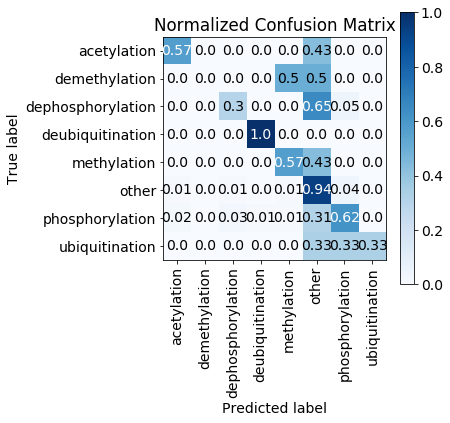

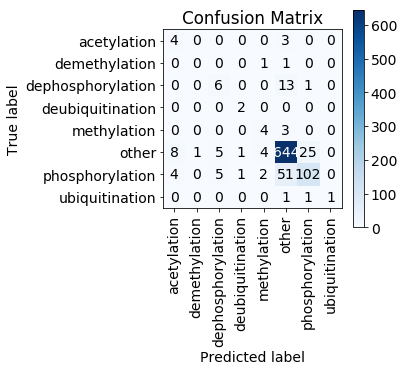

In [24]:
plot_confusion_matrix(df_single_test_results)

In [25]:
def plot_pr_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())
    
    skplt.metrics.plot_precision_recall(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))



In [26]:
def plot_roc_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())


    skplt.metrics.plot_roc(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))





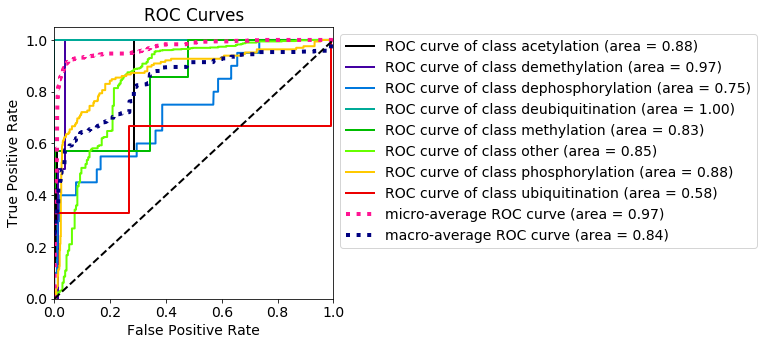

In [27]:
plot_roc_curve(df_single_test_results)

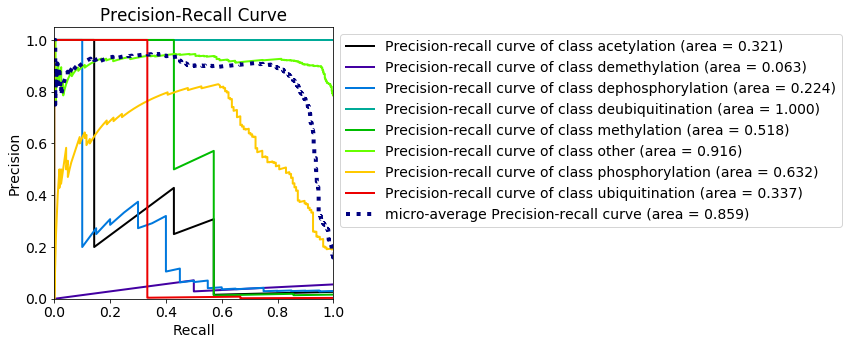

In [28]:
plot_pr_curve(df_single_test_results)


## Training / Validation epoch fit

In [29]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [30]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
54,54,3.390856,98.973797
53,53,3.457244,98.966646
64,64,2.967948,98.961337
62,62,3.808389,98.936131
61,61,3.627413,98.901122
63,63,4.979595,98.891725
66,66,3.689085,98.853903
57,57,4.332291,98.838719
51,51,4.309092,98.808714
60,60,4.036671,98.796451


In [31]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
46,46,57.225372,49.308367
53,53,53.640128,48.903075
61,61,59.399389,46.647083
36,36,50.904879,45.056540
34,34,47.869467,44.548877
24,24,47.984016,44.398632
37,37,50.479884,43.713973
57,57,59.542782,43.623593
32,32,49.630450,43.546953
66,66,57.197902,43.358709


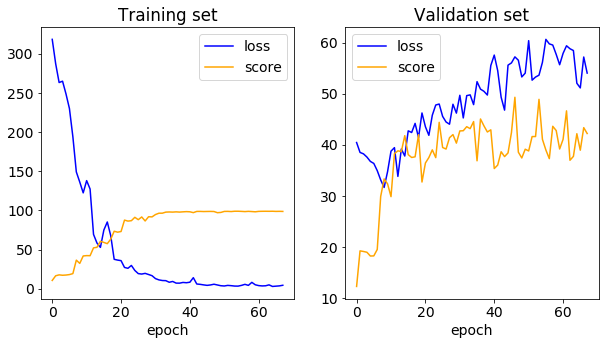

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

## Variation Bert - Objective F-score

In [33]:
import boto3
import re

def search_log(stream_names, filter_pattern, regex_pattern):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )
    assert len(response["events"]) == 1
    log_message = response["events"][0]["message"]
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    result = prog.match(log_message)
    
    return result



def get_prf(stream_names, filterPattern):
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)


    
def get_val_macro_score(stream_names):
    filterPattern =  '"__main__ - INFO - macro average scores"'
    return get_prf(stream_names, filterPattern)

def get_val_micro_score(stream_names):
    filterPattern =  '"__main__ - INFO - micro average scores"'
    return get_prf(stream_names, filterPattern)

def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [34]:
#precision, recall, fscore
jobs = [
 "ppi-bert-2020-12-13-10-51-25-188"
,"ppi-bert-2020-12-13-10-50-44-295"
,"ppi-bert-2020-12-13-10-50-01-820"
,"ppi-bert-2020-12-13-10-49-16-863"
,"ppi-bert-2020-12-13-10-48-25-273"
,"ppi-bert-2020-12-13-10-47-49-841"
,"ppi-bert-2020-12-13-10-46-54-644"
,"ppi-bert-2020-12-13-10-46-02-428"
,"ppi-bert-2020-12-13-10-45-08-793"
,"ppi-bert-2020-12-13-10-44-07-422"
]

In [35]:
import pandas as pd

val_scores = []
for j in jobs:
    l = get_log_name(j)
    precision, recall, fmacro = get_val_macro_score([l])
    fmicro = get_val_micro_score([l])[2]
    val_scores.append({"jobname": j, "precision":precision*100, "recall": recall*100, "f1-macro": fmacro*100,"f1-micro": fmicro*100})

df_val_variation_scores = pd.DataFrame(val_scores)

In [36]:
df_val_variation_scores .describe()

,f1-macro,f1-micro,precision,recall
count,10.000000,10.000000,10.000000,10.000000
mean,43.496080,78.642857,47.260360,43.509433
std,3.815629,3.295419,5.501584,6.051916
min,37.783595,71.904762,39.162811,35.595936
25%,40.958351,77.678571,44.240615,39.602392
50%,42.644197,78.809524,46.425727,43.074852
75%,46.061098,80.416667,48.968231,44.819592
max,49.138463,83.809524,57.824238,56.787104


In [37]:
best_val_job = df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]["jobname"]

In [38]:
df_val_variation_scores.head(n=10)

,f1-macro,f1-micro,jobname,precision,recall
0,42.899958,78.809524,ppi-bert-2020-12-13-10-51-25-188,45.496277,44.475053
1,42.388436,80.238095,ppi-bert-2020-12-13-10-50-44-295,44.112838,41.695579
2,41.905043,83.809524,ppi-bert-2020-12-13-10-50-01-820,49.271348,39.157723
3,49.010582,81.190476,ppi-bert-2020-12-13-10-49-16-863,57.824238,44.934439
4,44.877607,80.476190,ppi-bert-2020-12-13-10-48-25-273,47.355177,44.454125
5,40.642786,78.809524,ppi-bert-2020-12-13-10-47-49-841,54.189005,35.595936
6,49.138463,77.380952,ppi-bert-2020-12-13-10-46-54-644,48.058880,56.787104
7,46.455595,75.238095,ppi-bert-2020-12-13-10-46-02-428,44.623945,48.914474
8,37.783595,71.904762,ppi-bert-2020-12-13-10-45-08-793,39.162811,38.143499
9,39.858738,78.571429,ppi-bert-2020-12-13-10-44-07-422,42.509084,40.936398


In [39]:
df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]

f1-macro                              49.1385
f1-micro                               77.381
jobname      ppi-bert-2020-12-13-10-46-54-644
precision                             48.0589
recall                                56.7871
Name: 6, dtype: object

In [40]:
from sklearn.metrics import classification_report



def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    
def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["class"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit



def create_classification_report(actual, pred, labels=None):
    score_report_dict = sklearn.metrics.classification_report(actual, pred, output_dict=True, labels=labels)

    score_report_dict_transformed = []
    
    summary = {}
    for k, v in score_report_dict.items():
        if k in ["accuracy" ]: 
          
            summary[k] = v
        else:

            score_report_dict_transformed.append(
                {
                    "InteractionType" : k,
                    "precision" : v["precision"],
                    "recall" : v["recall"],
                    "f1-score" : v["f1-score"],
                    "support" : v["support"]
                }
            )
        
    return pd.DataFrame(score_report_dict_transformed), summary
    
def get_all_classification_report(list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        labels = list(set(df["actual"].unique().tolist()) - set(['other']))
        df_classification_summary,_ = create_classification_report(df["actual"], df["predicted"], labels=labels)
        df_classification_summary["keypath"] = s3_path
        

        scores.append(df_classification_summary)
        
    return pd.concat(scores)




def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None) 
        score["Accuracy"] = 100*accuracy_score(df["actual"], df["predicted"])  


        scores.append(score)
        
    return pd.DataFrame(scores)


def get_ensemble (list_of_s3_path):
    scores = {}

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        scores[s3_path] = df
        
    return scores

In [41]:
%%time

s3_model_paths = []
for k in jobs:
    s3_path = s3_model_path_format.format(k)
    s3_model_paths.append(s3_path)

df_test_variation_scores =  get_all_scores(s3_model_paths)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

CPU times: user 1.21 s, sys: 423 ms, total: 1.64 s
Wall time: 43.2 s


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
df_test_variation_scores.describe()

,Accuracy,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000
mean,83.064877,40.722402,45.722963,41.489233
std,1.747419,5.895859,9.969051,6.381735
min,79.865772,32.161715,34.246202,31.157552
25%,81.935123,35.968659,36.931069,37.429166
50%,83.668904,40.201414,45.823075,39.752160
75%,84.144295,45.421323,50.537166,45.285259
max,84.899329,49.101747,66.055480,51.023372


In [43]:
df_test_variation_scores.head(n=2)

,Accuracy,F1-score,Precision,Recall,key
0,83.892617,49.101747,54.216617,51.023372,s3://aegovan-data/results/ppi-bert-2020-12-13-...
1,84.899329,44.204424,45.622919,43.982228,s3://aegovan-data/results/ppi-bert-2020-12-13-...


In [44]:
df_test_variation_scores.query("key == '{}'".format(s3_model_path_format.format(best_val_job)))

,Accuracy,F1-score,Precision,Recall,key
6,80.760626,37.208217,36.603482,45.719603,s3://aegovan-data/results/ppi-bert-2020-12-13-...


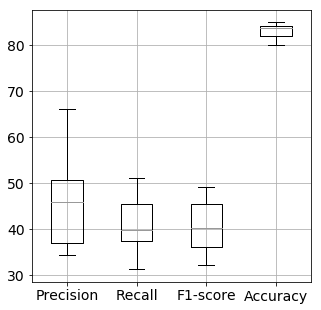

In [45]:

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.style.use('grayscale')

df_test_variation_scores[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax )
#ax.set_title( "BERT Variation - PPI typed dataset" )

plt.savefig("score_variation_typed.eps", bbox_inches='tight')





### Ensemble results

In [46]:
%%time

s3_model_paths = []
for k in jobs:
    job_name = k 
    s3_path = s3_model_path_format.format(job_name)
    s3_model_paths.append(s3_path)

ensemble_results =  get_ensemble(s3_model_paths)

CPU times: user 938 ms, sys: 424 ms, total: 1.36 s
Wall time: 1min


In [47]:
# vote_base="votes_{}"
# def populate_ensemble_predicted_confidence(ensemble_results_dict):
#     ensemble_results = list(ensemble_results_dict.values())
#     base_df= ensemble_results[0]
#     keys = list(base_df["confidence_scores"][0].keys())
#     vote_keys = [ vote_base.format(k) for k in keys]
#     result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
#     result["index"] = base_df.index
#     for v in vote_keys + keys:
#         result[v] = 0.0
#     # This is log softmax, convert to softmax prob
#     for df in ensemble_results:
#         for k in keys:
#             populate_predicted_confidence(df)
        
#             result[k] += df[k]
#             result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)


            
    
#     # populate voting
#     result["ensemble_predicted_confidence"] =  result.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )
#     result["ensemble_predicted"] =  result.apply(lambda r: keys[list(r[ keys]).index(max(r[ keys]))], axis=1  )


#     result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
#     result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
#     return result




In [48]:
# vote_base="votes_{}"
# def populate_ensemble_predicted_confidence(ensemble_results_dict):
#     ensemble_results = list(ensemble_results_dict.values())
#     base_df= ensemble_results[0]
#     keys = list(base_df["confidence_scores"][0].keys())
#     vote_keys = [ vote_base.format(k) for k in keys]
#     result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
#     result["index"] = base_df.index
#     for v in vote_keys :
#         result[v] = 0.0
#     for k in  keys:
#         result[k] = [[]]* result.shape[0]
#     # This is log softmax, convert to softmax prob
#     for df in ensemble_results:
#         populate_predicted_confidence(df)

#         for k in keys:
        
#             result[k] = result[k] + df[k].apply
#             result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)


            
    
# #     # populate voting
# #     result["ensemble_predicted_confidence"] =  result.apply(lambda r: max([sum(scores)/len(scores) for scores in r[ keys]]), axis=1 )
# #     result["ensemble_predicted"] =  result.apply(lambda r: keys[list(r[ keys]).index(max(r[ keys]))], axis=1  )


# #     result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
# #     result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
#     return result

In [49]:
import statistics
import numpy as np

vote_base="votes_{}"
raw_key_base="raw_{}"
def populate_ensemble_predicted_confidence(ensemble_results_dict):
    ensemble_results = list(ensemble_results_dict.values())
    base_df= ensemble_results[0]
    keys = list(base_df["confidence_scores"][0].keys())
    vote_keys = [ vote_base.format(k) for k in keys]
    result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id", "num_unique_gene_normalised_id", "num_gene_normalised_id"]  ]
    result["index"] = base_df.index
    for v in vote_keys :
        result[v] = 0.0
    for k in  keys:
         result[raw_key_base.format(k)] = [[]]* result.shape[0]
      
    # This is log softmax, convert to softmax prob
    for df in ensemble_results:
        df = get_softmax_confidence(df)

        for k in keys:
        
            result[raw_key_base.format(k)] = result[raw_key_base.format(k)] + df[k].apply(lambda x: [x])
            result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)

    
    for k in keys:        
        result[k] = result.apply(lambda r:np.mean(r[raw_key_base.format(k)]), axis=1) 
            
    raw_keys = [raw_key_base.format(k) for k in keys]
    # populate voting
    result["ensemble_predicted_confidence"] =  result.apply(lambda r: max([np.mean(en_score) for en_score in r[ raw_keys]]), axis=1 )
    result["ensemble_predicted"] =  result.apply(lambda r: keys[np.argmax([sum(en_score) for en_score in r[ raw_keys]])], axis=1 )


    result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
    result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
    return result

In [50]:
def get_best_result(df_dict, best_val_key):
    for k in df_dict:
        if best_val_key in k:
            return k,  df_dict[k]
      

In [51]:
k, best_raw_df = get_best_result(ensemble_results, best_val_job)



In [52]:
best_raw_df.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,class,predicted,confidence_scores,actual
0,16407301,MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-...,"[{'start': '0', 'end': '24', 'name': 'MAPK/ERK...",5,15,Q99759 (Q99759) is a mitogen-activated protein...,P52564,Q99759,other,other,"{'acetylation': -1.2522701025, 'demethylation'...",other
1,16407301,MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-...,"[{'start': '0', 'end': '24', 'name': 'MAPK/ERK...",5,15,Q99759 (Q99759) is a mitogen-activated protein...,Q16539,Q99759,other,other,"{'acetylation': -1.1586300135, 'demethylation'...",other
10,16511572,It has been shown that MDMX inhibits the activ...,"[{'start': '23', 'end': '27', 'name': 'MDMX', ...",5,27,It has been shown that O15151 inhibits the act...,O15151,P04637,other,other,"{'acetylation': -1.2527290583, 'demethylation'...",other
100,16938849,The mammalian Ste20-like Nck-interacting kinas...,"[{'start': '4', 'end': '13', 'name': 'mammalia...",4,12,The mammalian Q9Y6E0-like P97820 (P97820) and ...,P26038,O95819,other,other,"{'acetylation': -1.7884325981, 'demethylation'...",other
101,16938849,The mammalian Ste20-like Nck-interacting kinas...,"[{'start': '4', 'end': '13', 'name': 'mammalia...",4,12,The mammalian Q9Y6E0-like P97820 (P97820) and ...,P26038,Q9Y6E0,other,other,"{'acetylation': -1.6011999846, 'demethylation'...",other


In [53]:
best_df = get_softmax_confidence(best_raw_df)

In [54]:
%%time

df_ensemble = populate_ensemble_predicted_confidence(ensemble_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 59.8 s, sys: 1.34 s, total: 1min 1s
Wall time: 1min 3s


In [55]:
df_ensemble.query("ensemble_predicted == 'acetylation'").head(n=3)

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction
795,acetylation,Q01130 is a serine/arginine-rich protein belon...,Q01130,Q92993,6,13,795,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,"[0.2101748788832223, 0.6214169039153938, 0.923...","[0.012415707546281123, 0.05657660976347656, 0....","[0.005464922229584516, 0.034340785539904835, 0...","[0.02978201075867141, 0.03166204716611141, 0.1...","[0.014142110341923963, 0.04028880575909179, 0....","[0.9536768523980768, 0.8295953652532263, 0.388...","[0.12135207834390173, 0.058242239216704135, 0....","[0.3279333854376676, 0.19764538193503778, 0.23...",0.617891,0.103166,0.047531,0.133375,0.176284,0.50816,0.172505,0.259371,0.617891,acetylation,acetylation,0.617891
796,acetylation,Q01130 is a serine/arginine-rich protein belon...,Q01130,Q92993,6,13,796,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,"[0.2101748788832223, 0.6214169039153938, 0.923...","[0.012415707546281123, 0.05657660976347656, 0....","[0.005464922229584516, 0.034340785539904835, 0...","[0.02978201075867141, 0.03166204716611141, 0.1...","[0.014142110341923963, 0.04028880575909179, 0....","[0.9536768523980768, 0.8295953652532263, 0.388...","[0.12135207834390173, 0.058242239216704135, 0....","[0.3279333854376676, 0.19764538193503778, 0.23...",0.617891,0.103166,0.047531,0.133375,0.176284,0.50816,0.172505,0.259371,0.617891,acetylation,acetylation,0.617891
817,acetylation,The tumor suppressor P04637 and its close rela...,O15350,Q09472,6,14,817,8.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,"[0.937132884894552, 0.9090080163215785, 0.9110...","[0.17311965380061953, 0.1812897943293208, 0.09...","[0.045711562003950865, 0.16856634252136998, 0....","[0.16295319062212177, 0.07661917591938294, 0.1...","[0.533139349009054, 0.10921300309173777, 0.185...","[0.10296690300752015, 0.324739068767316, 0.515...","[0.06519735500701508, 0.06337358153454656, 0.0...","[0.19651925926352756, 0.17192675636904256, 0.2...",0.704108,0.141471,0.075526,0.173149,0.261314,0.29643,0.095456,0.318494,0.704108,acetylation,acetylation,0.704108


In [56]:
t= "acetylation"
df_ensemble.query(f"ensemble_predicted == '{t}'")[ raw_key_base.format(t)].iloc[0]

[0.2101748788832223,
 0.6214169039153938,
 0.923295222449124,
 0.8716396486146829,
 0.4433835944057872,
 0.012107329269981405,
 0.9360900684635588,
 0.34975814758496104,
 0.9523613901809458,
 0.8586822589326039]

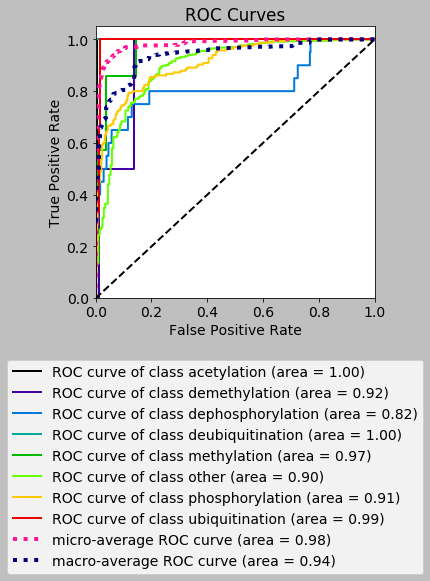

In [57]:

import matplotlib.pyplot as plt
import scikitplot as skplt
keys = list(best_df["confidence_scores"][0].keys())


skplt.metrics.plot_roc(df_ensemble["actual"], df_ensemble[keys], figsize=(5,5)).legend(bbox_to_anchor=(1.2,-0.2))


plt.savefig("plot_roc_ensemble.eps", bbox_inches='tight')


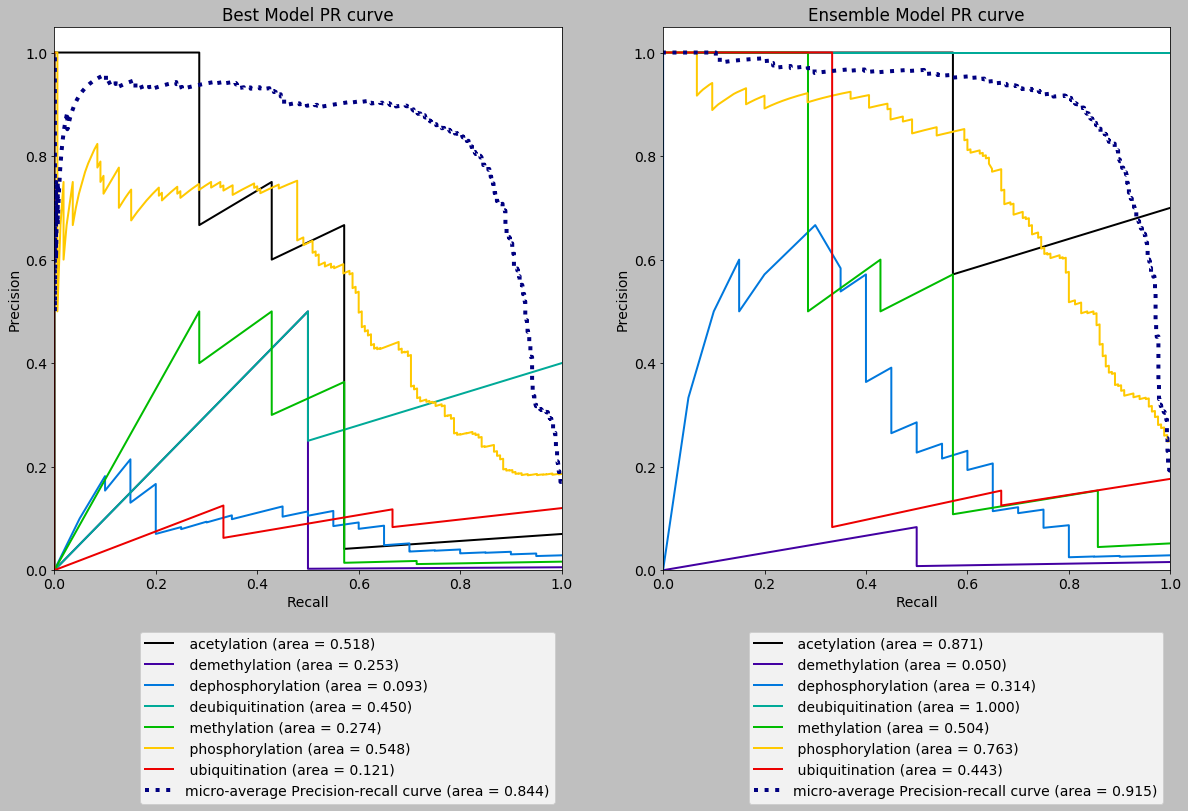

In [58]:

import matplotlib.pyplot as plt
import scikitplot as skplt
classes_to_plot = list( set(list(best_df["confidence_scores"][0].keys()))-set(['other']))

keys = list(best_df["confidence_scores"][0].keys())

fig, ax = plt.subplots(1,2, figsize=(20,10))

axi=ax[0]
skplt.metrics.plot_precision_recall(best_df["actual"], best_df[keys], ax=axi, title="Best Model PR curve", classes_to_plot=classes_to_plot)
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("Precision-recall curve of class","") for l in labels], bbox_to_anchor=(1.0,-0.1))

axi=ax[1]
skplt.metrics.plot_precision_recall(df_ensemble["actual"], df_ensemble[keys], ax=axi,title="Ensemble Model PR curve", classes_to_plot=classes_to_plot).legend(bbox_to_anchor=(1.2,-0.2))
_, labels = axi.get_legend_handles_labels()
axi.legend([l.replace("Precision-recall curve of class","") for l in labels], bbox_to_anchor=(1.0,-0.1))





plt.savefig("PlotPRCurveOnTest.pdf", bbox_inches='tight')



### Get thresholds to use

In [59]:
import sklearn
from sklearn.preprocessing import label_binarize
import numpy as np 

def get_thrsholds(df, field_actual, classes, confidence_colms):
    result = []
    actual_binarized = label_binarize(df[field_actual], classes=classes)
    predicted_binarized = np.true_divide(df[confidence_colms].values, df[confidence_colms].values.sum(axis=1, keepdims=True)) 
    #predicted_binarized[predicted_binarized < 0.5] = 0.0
    for i in range(actual_binarized.shape[1]):
        
        _, _, thres = sklearn.metrics.precision_recall_curve(actual_binarized[:,i],predicted_binarized[:,i])
  
        best_pr = -1
        pr = []
        rc = []
        for ti, t in enumerate(thres):
            p_full = predicted_binarized[:,i]
            a_full = actual_binarized[:,i]
            #a = a_full[p_full >= t]
            p_label = ( (p_full >= t) & (t > 0.5)).astype(int)
            
#             cut_off = 0.5 if t < 0.5 else t
#             p_label = (p>0.5).astype(int)

            pr.append( sklearn.metrics.precision_score(a_full,p_label, average='binary' ,sample_weight=None))
            rc.append(sklearn.metrics.recall_score(a_full,p_label))
            
            if best_pr < pr[-1]:
                idx =  ti
            if best_pr == 1.0:
                break
            

#         print(keys[i])
#         print(np.round(pr,4))
#         print(np.round(thres,4))



        #get first / lowest index of highest precision
        #last element then it is always one.. so not applicable
        # idx = np.argmax(pr[:-1])
       
        result.append( {
            "key" : keys[i],
            "threshold" :  thres[idx-1],
            "precision" : pr[idx],
            "recall" : rc[idx]
        })
    return result




In [60]:
df_ensemble_best_threshold = pd.DataFrame(get_thrsholds(df_ensemble, field_actual = "actual", classes =keys,confidence_colms=keys ))
df_ensemble_best_threshold

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,key,precision,recall,threshold
0,acetylation,0.0,0.000000,0.306147
1,demethylation,0.0,0.000000,0.064110
2,dephosphorylation,0.0,0.000000,0.340067
3,deubiquitination,0.0,0.000000,0.218855
4,methylation,1.0,0.285714,0.407134
5,other,1.0,0.001453,0.707600
6,phosphorylation,1.0,0.006061,0.833036
7,ubiquitination,0.0,0.000000,0.297822


In [61]:
df_ensemble.query("actual == 'deubiquitination' or ensemble_predicted == 'deubiquitination'")[[ "actual", "ensemble_predicted", "ensemble_predicted_confidence"]].sort_values(by = ["ensemble_predicted_confidence"])

,actual,ensemble_predicted,ensemble_predicted_confidence
776,deubiquitination,ubiquitination,0.555275
727,deubiquitination,deubiquitination,0.619401


### Get Scores

In [62]:
df_ensemble.shape

(894, 35)

In [63]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"],sample_weight=None)
print(scores)



{'F1_macro': 0.49431299727222955, 'precision_macro': 0.6163639236182277, 'recall_macro': 0.43881694855532066, 'F1_micro': 0.8557046979865772, 'accuracy': 0.8557046979865772}


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


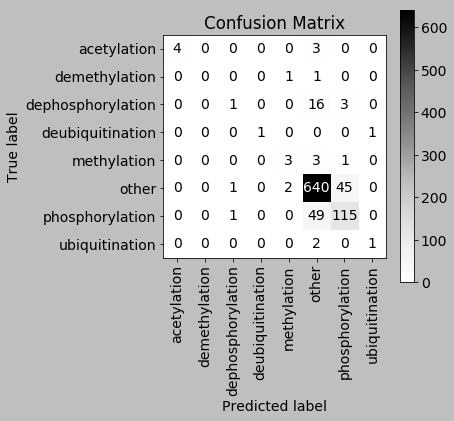

In [64]:
import matplotlib.pyplot as plt
import scikitplot as skplt

fig,ax = plt.subplots(1, 1, figsize=(5,5))


# skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], normalize=True , ax=ax[0],  x_tick_rotation=90)
# plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], ax=ax, normalize=False, x_tick_rotation=90, cmap="Greys" )
plt.savefig("confusionmatrix_unnormalised.eps", bbox_inches='tight')



In [102]:
from sklearn.metrics import confusion_matrix
# Specify label order
labels = ['other', 'acetylation','methylation','demethylation','phosphorylation','dephosphorylation','ubiquitination','deubiquitination'   ] 
confusion_df = pd.DataFrame(data= confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=labels), index=labels, columns=labels)

confusion_df.to_csv("confusion.matrix.csv")


In [103]:
print(confusion_df.to_latex().replace("lation", ".").replace("ination", "."))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  other &  acety. &  methy. &  demethy. &  phosphory. &  dephosphory. &  ubiquit. &  deubiquit. \\
\midrule
other             &    640 &            0 &            2 &              0 &               45 &                  1 &               0 &                 0 \\
acety.       &      3 &            4 &            0 &              0 &                0 &                  0 &               0 &                 0 \\
methy.       &      3 &            0 &            3 &              0 &                1 &                  0 &               0 &                 0 \\
demethy.     &      1 &            0 &            1 &              0 &                0 &                  0 &               0 &                 0 \\
phosphory.   &     49 &            0 &            0 &              0 &              115 &                  1 &               0 &                 0 \\
dephosphory. &     16 &            0 &            0 &              0 &                3 &        

In [67]:
pos_labels = list(set(df_ensemble["actual"].unique().tolist()) - set(['other']))
df_ensemble_classwise_report, summary_ensemble = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
df_ensemble_classwise_report

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,InteractionType,f1-score,precision,recall,support
0,dephosphorylation,0.086957,0.333333,0.050000,20
1,methylation,0.461538,0.500000,0.428571,7
2,ubiquitination,0.400000,0.500000,0.333333,3
3,phosphorylation,0.699088,0.701220,0.696970,165
4,deubiquitination,0.666667,1.000000,0.500000,2
5,acetylation,0.727273,1.000000,0.571429,7
6,demethylation,0.000000,0.000000,0.000000,2
7,micro avg,0.647668,0.694444,0.606796,206
8,macro avg,0.434503,0.576365,0.368615,206
9,weighted avg,0.621086,0.661980,0.606796,206


In [68]:
pos_labels = list(set(best_df["actual"].unique().tolist()) - set(['other']))
best_df_classwise_report, summary_ensemble = create_classification_report(best_df["actual"], best_df["predicted"], labels=pos_labels)
best_df_classwise_report

,InteractionType,f1-score,precision,recall,support
0,dephosphorylation,0.166667,0.142857,0.200000,20
1,methylation,0.444444,0.363636,0.571429,7
2,ubiquitination,0.000000,0.000000,0.000000,3
3,phosphorylation,0.500000,0.746988,0.375758,165
4,deubiquitination,0.400000,0.250000,1.000000,2
5,acetylation,0.571429,0.571429,0.571429,7
6,demethylation,0.000000,0.000000,0.000000,2
7,micro avg,0.443149,0.554745,0.368932,206
8,macro avg,0.297506,0.296416,0.388374,206
9,weighted avg,0.455070,0.646386,0.368932,206


In [104]:
print(df_ensemble_classwise_report.merge( best_df_classwise_report,suffixes= ('.e', '.s'), on="InteractionType" ).drop("support.e", axis=1).sort_values(by=["InteractionType"]).to_latex(index=False, float_format =lambda x: "{:.2%}".format(x)).replace("\\%",""))

\begin{tabular}{lrrrrrrr}
\toprule
   InteractionType &  f1-score.e &  precision.e &  recall.e &  f1-score.s &  precision.s &  recall.s &  support.s \\
\midrule
       acetylation &      72.73 &      100.00 &    57.14 &      57.14 &       57.14 &    57.14 &          7 \\
     demethylation &       0.00 &        0.00 &     0.00 &       0.00 &        0.00 &     0.00 &          2 \\
 dephosphorylation &       8.70 &       33.33 &     5.00 &      16.67 &       14.29 &    20.00 &         20 \\
  deubiquitination &      66.67 &      100.00 &    50.00 &      40.00 &       25.00 &   100.00 &          2 \\
         macro avg &      43.45 &       57.64 &    36.86 &      29.75 &       29.64 &    38.84 &        206 \\
       methylation &      46.15 &       50.00 &    42.86 &      44.44 &       36.36 &    57.14 &          7 \\
         micro avg &      64.77 &       69.44 &    60.68 &      44.31 &       55.47 &    36.89 &        206 \\
   phosphorylation &      69.91 &       70.12 &    69.70 &    

In [70]:
pos_labels = ['acetylation','phosphorylation', 'methylation', 'dephosphorylation']
df_ensemble_sample_size_classwise_report, _ = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
best_df_sample_size_classwise_report,_= create_classification_report(best_df["actual"], best_df["predicted"], labels=pos_labels) 

df_ensemble_sample_size_classwise_report



,InteractionType,f1-score,precision,recall,support
0,acetylation,0.727273,1.000000,0.571429,7
1,phosphorylation,0.699088,0.701220,0.696970,165
2,methylation,0.461538,0.500000,0.428571,7
3,dephosphorylation,0.086957,0.333333,0.050000,20
4,micro avg,0.654255,0.694915,0.618090,199
5,macro avg,0.493714,0.633638,0.436742,199
6,weighted avg,0.630203,0.667678,0.618090,199


In [71]:
print(df_ensemble_sample_size_classwise_report.merge(best_df_sample_size_classwise_report, on="InteractionType", suffixes=[".e", ",b"]).drop("support.e", axis=1).to_latex(index=False, float_format =lambda x: "{:.2%}".format(x)).replace("\\%",""))

\begin{tabular}{lrrrrrrr}
\toprule
   InteractionType &  f1-score.e &  precision.e &  recall.e &  f1-score,b &  precision,b &  recall,b &  support,b \\
\midrule
       acetylation &      72.73 &      100.00 &    57.14 &      57.14 &       57.14 &    57.14 &          7 \\
   phosphorylation &      69.91 &       70.12 &    69.70 &      50.00 &       74.70 &    37.58 &        165 \\
       methylation &      46.15 &       50.00 &    42.86 &      44.44 &       36.36 &    57.14 &          7 \\
 dephosphorylation &       8.70 &       33.33 &     5.00 &      16.67 &       14.29 &    20.00 &         20 \\
         micro avg &      65.43 &       69.49 &    61.81 &      45.12 &       57.36 &    37.19 &        199 \\
         macro avg &      49.37 &       63.36 &    43.67 &      42.06 &       45.62 &    42.97 &        199 \\
      weighted avg &      63.02 &       66.77 &    61.81 &      46.71 &       66.66 &    37.19 &        199 \\
\bottomrule
\end{tabular}



In [72]:
df_ensemble["particpant1Exists"] = df_ensemble.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpant2Exists"] = df_ensemble.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpantsExists"] = df_ensemble.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)




In [73]:
df_ensemble.query("actual != ensemble_predicted  and  particpantsExists"  )[["ensemble_predicted", "actual","normalised_abstract", "participant1Id", "participant2Id"]].sample(n=10)

,ensemble_predicted,actual,normalised_abstract,participant1Id,participant2Id
277,phosphorylation,other,Activation of resting T lymphocytes initiates ...,Q13523,P13501
17,phosphorylation,other,It has been shown that O15151 inhibits the act...,O15151,P61981
229,phosphorylation,other,Q06187 (Q06187) is essential for B cell activa...,Q06187,P12931
342,methylation,other,Histone methylation regulates chromatin struct...,O60341,P41229
410,phosphorylation,other,In examining the protein kinase components of ...,O95747,P38936
750,other,phosphorylation,"In metazoans, the Ras-Q9Y6X8-O14733 (mitogen-a...",P29678,Q6VAB6-1
798,other,methylation,The protein lysine methyltransferase Q8WTS6 re...,Q8WTS6,P26358
488,phosphorylation,other,An intercentrosomal linker keeps a cell's two ...,Q76N32,Q96SN8
333,phosphorylation,other,Phosphorylation of the reduced nicotinamide ad...,Q05655,P20138
88,phosphorylation,other,P56537 (P56537) controls translation by regula...,P04637,P56537


In [74]:
df_ensemble.query("not particpantsExists").shape , df_ensemble.query("not particpantsExists and actual != ensemble_predicted").shape, df_ensemble.shape

((96, 38), (21, 38), (894, 38))

In [75]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"],sample_weight=None)
print(scores)



{'F1_macro': 0.4999054471657211, 'precision_macro': 0.5636801022811386, 'recall_macro': 0.4763446340481224, 'F1_micro': 0.854586129753915, 'accuracy': 0.854586129753915}


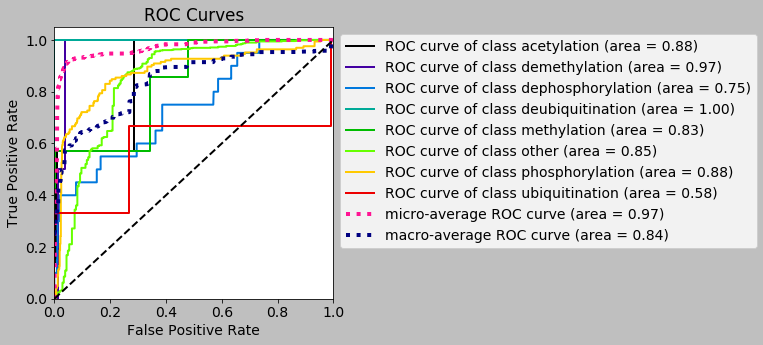

In [76]:
plot_roc_curve(df_single_test_results)

In [77]:
df_ensemble.head(n=2)

,actual,normalised_abstract,participant1Id,participant2Id,num_unique_gene_normalised_id,num_gene_normalised_id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,raw_acetylation,raw_demethylation,raw_dephosphorylation,raw_deubiquitination,raw_methylation,raw_other,raw_phosphorylation,raw_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction,particpant1Exists,particpant2Exists,particpantsExists
0,other,Q99759 (Q99759) is a mitogen-activated protein...,P52564,Q99759,5,15,0,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,"[0.002505094966863287, 0.00137328048843793, 0....","[0.0017022695139870723, 0.0006274469601815494,...","[0.0030547879996229237, 0.004742262010353656, ...","[0.0007619646808905866, 0.0017854078084803598,...","[0.0018714479198418397, 0.0011470238742479623,...","[0.9900516467696749, 0.9959773714002509, 0.719...","[0.4725885976620421, 0.3055426114448398, 0.897...","[0.19804206888140471, 0.20362166642155094, 0.0...",0.003318,0.001556,0.104189,0.004366,0.002883,0.905056,0.616158,0.142465,0.905056,other,other,0.905056,True,True,True
1,other,Q99759 (Q99759) is a mitogen-activated protein...,Q16539,Q99759,5,15,1,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,"[0.004644507950238717, 0.0010985024113907625, ...","[0.0009662648218764262, 0.0005442243671413711,...","[0.014032581268707526, 0.008299298528812173, 0...","[0.0026402156116384157, 0.0009773086770484564,...","[0.0009969639962198287, 0.0010506940645073962,...","[0.9649169318004756, 0.9950283831984343, 0.795...","[0.7209108222805294, 0.4150192784283834, 0.866...","[0.12977951471134305, 0.12366963110815235, 0.0...",0.002582,0.001146,0.075135,0.002922,0.001956,0.955792,0.516516,0.148681,0.955792,other,other,0.955792,True,True,True


In [78]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

def probability_threshold(df, confidence_field, predicted_field):
    result = []
    l, u = min(df[confidence_field]), max(df[confidence_field])
    threshold = 0
    step = round( (u-0)/50, 2)
    majority_class = df.groupby(["actual"]).size().idxmax()
    max_valuecounts =  df.groupby(["actual"]).size().max()
    while threshold <= u :
        df_filter = df.query("{} >=  {}".format(confidence_field, threshold))
        max_valuecounts_filter = df_filter.query("actual == '{}'".format(majority_class)).shape[0]


        result.append ({
            "baseline_accuracy" : max_valuecounts/df.shape[0],
            "baseline_accuracy_threshold" : max_valuecounts_filter/df_filter.shape[0],
            "threshold" : threshold,
            "records" : df_filter.shape[0],
            "percentage_records_retained" : df_filter.shape[0]/df.shape[0],
            "normalised_threshold" : (threshold -0 )/(u-0),
            "F1_macro": f1_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None)  ,
            "precision_macro":precision_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "recall_macro": recall_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "F1_micro":    f1_score(df_filter["actual"], df_filter[predicted_field], average='micro' ,sample_weight=None) ,
            "accuracy":accuracy_score(df_filter["actual"], df_filter[predicted_field],sample_weight=None)
        })
        threshold += step
        
    return pd.DataFrame(result)



In [79]:
pt_ensemble_majority_prediction = probability_threshold(df_ensemble,"ensemble_confidence_majority_prediction", "ensemble_majority_prediction")
pt_ensemble_prediction = probability_threshold(df_ensemble,"ensemble_predicted_confidence", "ensemble_predicted")
pt_best_prediction = probability_threshold(best_df,"predicted_confidence", "predicted")

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


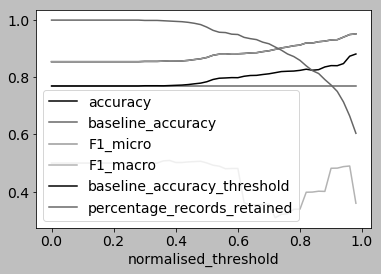

In [80]:
pt_ensemble_majority_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" ,"F1_micro", "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold")

In [81]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=False).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
49,0.359345,0.951852,0.951852,0.769575,0.881481,0.980658,0.604027,0.373702,0.348319,540,0.98
48,0.489742,0.949495,0.949495,0.769575,0.873737,0.960645,0.664430,0.574702,0.443074,594,0.96
47,0.487525,0.940439,0.940439,0.769575,0.847962,0.940632,0.713647,0.573475,0.440680,638,0.94
46,0.482208,0.931446,0.931446,0.769575,0.840537,0.920618,0.750559,0.567490,0.436170,671,0.92
45,0.481776,0.930535,0.930535,0.769575,0.840810,0.900605,0.772931,0.563878,0.437452,691,0.90
44,0.400830,0.926554,0.926554,0.769575,0.836158,0.880591,0.791946,0.468224,0.364628,708,0.88
43,0.401508,0.924347,0.924347,0.769575,0.826685,0.860578,0.813199,0.468081,0.365845,727,0.86
42,0.398500,0.919837,0.919837,0.769575,0.824728,0.840564,0.823266,0.465840,0.362477,736,0.84
41,0.397921,0.920107,0.920107,0.769575,0.828229,0.820551,0.840045,0.464526,0.362282,751,0.82
40,0.338873,0.912760,0.912760,0.769575,0.824219,0.800537,0.859060,0.395816,0.308642,768,0.80


In [82]:
df_ensemble.query("ensemble_confidence_majority_prediction > 12095")["actual"].value_counts()

Series([], Name: actual, dtype: int64)

In [83]:
df_ensemble.to_json("test_ensemble.json")

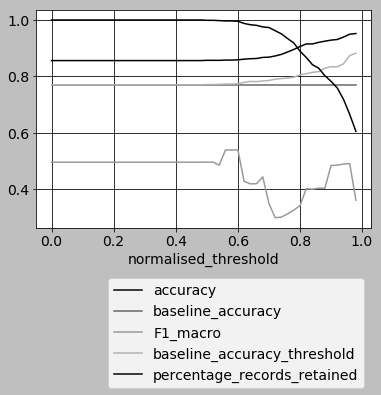

In [84]:
pt_ensemble_prediction   [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_ensmebl.png", bbox_inches='tight')

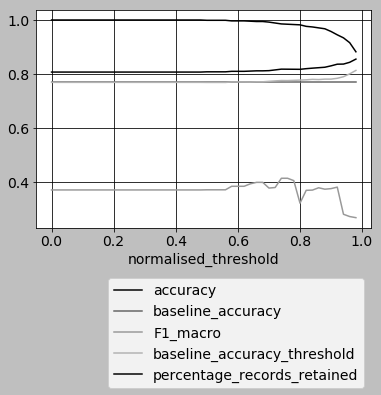

In [85]:
pt_best_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_best.png", bbox_inches='tight')

In [86]:
pt_ensemble_prediction.sort_values(by=["threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.494313,0.855705,0.855705,0.769575,0.769575,0.000000,1.0,0.616364,0.438817,894,0.00
1,0.494313,0.855705,0.855705,0.769575,0.769575,0.020013,1.0,0.616364,0.438817,894,0.02
2,0.494313,0.855705,0.855705,0.769575,0.769575,0.040027,1.0,0.616364,0.438817,894,0.04
3,0.494313,0.855705,0.855705,0.769575,0.769575,0.060040,1.0,0.616364,0.438817,894,0.06
4,0.494313,0.855705,0.855705,0.769575,0.769575,0.080054,1.0,0.616364,0.438817,894,0.08
5,0.494313,0.855705,0.855705,0.769575,0.769575,0.100067,1.0,0.616364,0.438817,894,0.10
6,0.494313,0.855705,0.855705,0.769575,0.769575,0.120081,1.0,0.616364,0.438817,894,0.12
7,0.494313,0.855705,0.855705,0.769575,0.769575,0.140094,1.0,0.616364,0.438817,894,0.14
8,0.494313,0.855705,0.855705,0.769575,0.769575,0.160107,1.0,0.616364,0.438817,894,0.16
9,0.494313,0.855705,0.855705,0.769575,0.769575,0.180121,1.0,0.616364,0.438817,894,0.18


In [87]:
pt_best_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.372082,0.807606,0.807606,0.769575,0.769575,0.000000,1.0,0.366035,0.457196,894,0.00
1,0.372082,0.807606,0.807606,0.769575,0.769575,0.020008,1.0,0.366035,0.457196,894,0.02
2,0.372082,0.807606,0.807606,0.769575,0.769575,0.040016,1.0,0.366035,0.457196,894,0.04
3,0.372082,0.807606,0.807606,0.769575,0.769575,0.060024,1.0,0.366035,0.457196,894,0.06
4,0.372082,0.807606,0.807606,0.769575,0.769575,0.080032,1.0,0.366035,0.457196,894,0.08
5,0.372082,0.807606,0.807606,0.769575,0.769575,0.100040,1.0,0.366035,0.457196,894,0.10
6,0.372082,0.807606,0.807606,0.769575,0.769575,0.120048,1.0,0.366035,0.457196,894,0.12
7,0.372082,0.807606,0.807606,0.769575,0.769575,0.140056,1.0,0.366035,0.457196,894,0.14
8,0.372082,0.807606,0.807606,0.769575,0.769575,0.160064,1.0,0.366035,0.457196,894,0.16
9,0.372082,0.807606,0.807606,0.769575,0.769575,0.180072,1.0,0.366035,0.457196,894,0.18


In [88]:
k

's3://aegovan-data/results/ppi-bert-2020-12-13-10-46-54-644/output/output.tar.gz'

In [89]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.499905,0.854586,0.854586,0.769575,0.769575,0.000000,1.0,0.56368,0.476345,894,0.00
1,0.499905,0.854586,0.854586,0.769575,0.769575,0.020013,1.0,0.56368,0.476345,894,0.02
2,0.499905,0.854586,0.854586,0.769575,0.769575,0.040027,1.0,0.56368,0.476345,894,0.04
3,0.499905,0.854586,0.854586,0.769575,0.769575,0.060040,1.0,0.56368,0.476345,894,0.06
4,0.499905,0.854586,0.854586,0.769575,0.769575,0.080054,1.0,0.56368,0.476345,894,0.08
5,0.499905,0.854586,0.854586,0.769575,0.769575,0.100067,1.0,0.56368,0.476345,894,0.10
6,0.499905,0.854586,0.854586,0.769575,0.769575,0.120081,1.0,0.56368,0.476345,894,0.12
7,0.499905,0.854586,0.854586,0.769575,0.769575,0.140094,1.0,0.56368,0.476345,894,0.14
8,0.499905,0.854586,0.854586,0.769575,0.769575,0.160107,1.0,0.56368,0.476345,894,0.16
9,0.499905,0.854586,0.854586,0.769575,0.769575,0.180121,1.0,0.56368,0.476345,894,0.18


## Gene mentions impact

In [90]:
print(df_ensemble.query("actual != 'other'")["num_unique_gene_normalised_id"].describe(percentiles= [ f/100 for f in range(0,110, 10)]).to_latex(float_format = lambda x:  '{:.2f}'.format(x)))

\begin{tabular}{lr}
\toprule
{} &  num\_unique\_gene\_normalised\_id \\
\midrule
count &                         206.00 \\
mean  &                           4.08 \\
std   &                           2.09 \\
min   &                           1.00 \\
0\%    &                           1.00 \\
10\%   &                           2.00 \\
20\%   &                           2.00 \\
30\%   &                           3.00 \\
40\%   &                           3.00 \\
50\%   &                           4.00 \\
60\%   &                           4.00 \\
70\%   &                           5.00 \\
80\%   &                           6.00 \\
90\%   &                           7.00 \\
100\%  &                          11.00 \\
max   &                          11.00 \\
\bottomrule
\end{tabular}



In [91]:
df_ensemble.query("actual != 'other'")\
.groupby(["actual"])["num_unique_gene_normalised_id"]\
.describe(percentiles= [ f/100 for f in range(0,110, 10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
actual,,,,,,,,,,,,,,,,
acetylation,7.0,4.142857,1.772811,2.0,2.0,2.6,3.0,3.0,3.0,3.0,4.8,6.0,6.0,6.0,6.0,6.0
demethylation,2.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
dephosphorylation,20.0,4.400000,1.818038,1.0,1.0,2.0,3.0,3.0,4.0,4.5,5.0,5.3,6.0,6.1,8.0,8.0
deubiquitination,2.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
methylation,7.0,3.857143,1.214986,2.0,2.0,2.6,3.0,3.0,3.4,4.0,4.6,5.0,5.0,5.0,5.0,5.0
phosphorylation,165.0,4.030303,2.207040,1.0,1.0,1.4,2.0,3.0,3.0,3.0,4.0,5.0,6.0,7.0,11.0,11.0
ubiquitination,3.0,4.666667,1.154701,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.4,4.8,5.2,5.6,6.0,6.0


In [92]:
print(df_ensemble.query("actual != 'other'")\
.groupby(["actual"])["num_unique_gene_normalised_id"]\
.describe()\
.to_latex(float_format = lambda x:  '{:.2f}'.format(x)))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &  std &  min &  25\% &  50\% &  75\% &   max \\
actual            &        &       &      &      &      &      &      &       \\
\midrule
acetylation       &   7.00 &  4.14 & 1.77 & 2.00 & 3.00 & 3.00 & 6.00 &  6.00 \\
demethylation     &   2.00 &  5.00 & 0.00 & 5.00 & 5.00 & 5.00 & 5.00 &  5.00 \\
dephosphorylation &  20.00 &  4.40 & 1.82 & 1.00 & 3.00 & 4.50 & 6.00 &  8.00 \\
deubiquitination  &   2.00 &  4.00 & 0.00 & 4.00 & 4.00 & 4.00 & 4.00 &  4.00 \\
methylation       &   7.00 &  3.86 & 1.21 & 2.00 & 3.00 & 4.00 & 5.00 &  5.00 \\
phosphorylation   & 165.00 &  4.03 & 2.21 & 1.00 & 3.00 & 3.00 & 6.00 & 11.00 \\
ubiquitination    &   3.00 &  4.67 & 1.15 & 4.00 & 4.00 & 4.00 & 5.00 &  6.00 \\
\bottomrule
\end{tabular}



In [93]:
from datetime import datetime
def summarize_impact_unique_gene_count(df):
    
    size_genes = df ["num_unique_gene_normalised_id"] .unique().tolist()
    
    pos_labels = list(set(df["actual"].unique().tolist()) - set(['other']))

    frames =[]
    for i in  size_genes:
        print(datetime.now(),"Running for size ", i)
        
        df_size = df.query("num_unique_gene_normalised_id == {}".format(i))

        df_class_wise_report,_ = create_classification_report(df_size["actual"], df_size["ensemble_predicted"], labels=pos_labels)
        
        df_class_wise_report["unique_gene_count"] = i
        
        frames.append(df_class_wise_report)
        
    df = pd.concat(frames)
    
    return df


In [94]:
df_size_summary = summarize_impact_unique_gene_count(df_ensemble)

2020-12-20 16:46:18.538482 Running for size  5
2020-12-20 16:46:18.555096 Running for size  4
2020-12-20 16:46:18.571610 Running for size  6
2020-12-20 16:46:18.591595 Running for size  7
2020-12-20 16:46:18.611092 Running for size  8
2020-12-20 16:46:18.622176 Running for size  3
2020-12-20 16:46:18.633005 Running for size  11
2020-12-20 16:46:18.641391 Running for size  2
2020-12-20 16:46:18.649117 Running for size  10
2020-12-20 16:46:18.657475 Running for size  9
2020-12-20 16:46:18.665680 Running for size  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
df_size_summary

,InteractionType,f1-score,precision,recall,support,unique_gene_count
0,dephosphorylation,0.000000,0.000000,0.000000,4,5
1,methylation,0.571429,0.500000,0.666667,3,5
2,ubiquitination,0.000000,0.000000,0.000000,0,5
3,phosphorylation,0.421053,0.347826,0.533333,15,5
4,deubiquitination,0.000000,0.000000,0.000000,0,5
5,acetylation,0.000000,0.000000,0.000000,0,5
6,demethylation,0.000000,0.000000,0.000000,2,5
7,micro avg,0.392157,0.370370,0.416667,24,5
8,macro avg,0.141783,0.121118,0.171429,24,5
9,weighted avg,0.334586,0.279891,0.416667,24,5


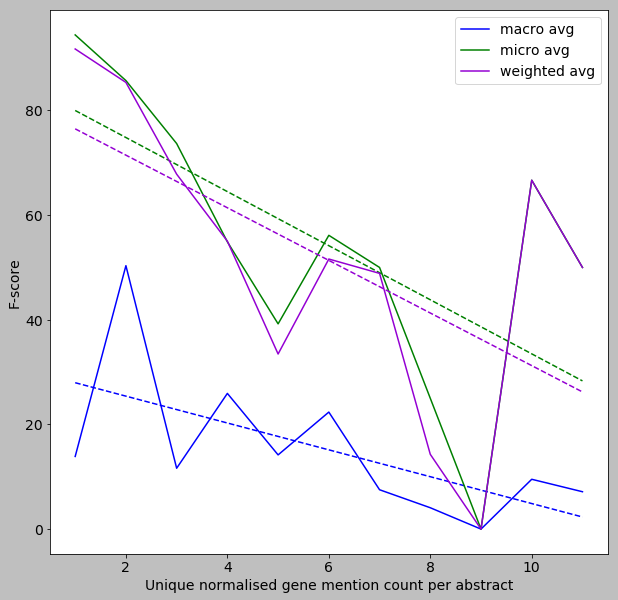

In [96]:
import numpy

fig, ax = plt.subplots(figsize=(10,10))


colors = ['blue', 'green',  "darkviolet"]

for c, (label, df_e) in zip(colors, df_size_summary.query("InteractionType in ['micro avg', 'macro avg', 'weighted avg']").groupby('InteractionType')):
    d = df_e.sort_values(by="unique_gene_count")
    d["f1-score"] = d['f1-score'].apply( lambda x: float( '{:.2%}'.format(x).replace("%", "")) )
    d.plot.line( ax=ax, label=label, x="unique_gene_count" , y="f1-score", color=c  )
    z = numpy.polyfit(d["unique_gene_count"], d["f1-score"], 1)
    p = numpy.poly1d(z)
    plt.plot(  d["unique_gene_count"], p(d["unique_gene_count"]), color=c ,  linestyle='dashed' )
    plt.xlabel("Unique normalised gene mention count per abstract")
    plt.ylabel("F-score")
    
plt.legend()

plt.savefig("GeneCountVsScore.pdf")


plt.show()



## Ensemble size impact

In [97]:
from datetime import datetime
def summarize_impact_ensemble_size(jobs):
    """
    Summarize impact of ensemble_size on prediction
    """
    s3_model_paths = []
    for k in jobs:
        job_name = k 
        s3_path = s3_model_path_format.format(job_name)
        s3_model_paths.append(s3_path)
    
    
    frames = []
    scores = []
    
    for i in range(1, len(s3_model_paths)):
        print(datetime.now(),"Running for ensemble ", i)
        # Compute individual scores
        df_score = get_all_classification_report(s3_model_paths[:i])
        df_score["ensemble_size"] = i
        scores.append(df_score)
        
        #Compute ensemble scores
        ensemble_results =  get_ensemble(s3_model_paths[:i])
        df_ensemble = populate_ensemble_predicted_confidence(ensemble_results)
        
        pos_labels = list(set(df_ensemble["actual"].unique().tolist()) - set(['other']))


        df_class_wise_report,_ = create_classification_report(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=pos_labels)
        
        df_class_wise_report["ensemble_size"] = i
        
        frames.append(df_class_wise_report)
        
    df = pd.concat(frames)
    df_scores =  pd.concat(scores)
    
    return df, df_scores
        
        

In [98]:
%%time

df_ensemble_size_compare, df_ensemble_scores = summarize_impact_ensemble_size(jobs)

2020-12-20 16:46:19.184887 Running for ensemble  1


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

2020-12-20 16:46:36.302598 Running for ensemble  2


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_lau

2020-12-20 16:47:13.314594 Running for ensemble  3


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

2020-12-20 16:48:17.139576 Running for ensemble  4


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-20 16:49:57.491803 Running for ensemble  5


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-20 16:52:07.112999 Running for ensemble  6


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-20 16:54:23.757351 Running for ensemble  7


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-20 16:56:41.312400 Running for ensemble  8


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2020-12-20 16:59:13.312882 Running for ensemble  9


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

CPU times: user 4min 49s, sys: 10.2 s, total: 4min 59s
Wall time: 15min 50s


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [99]:
df_ensemble_scores .query("InteractionType=='{}'".format("phosphorylation")).groupby("ensemble_size").describe()

f1-score                                                    \
                 count      mean       std       min       25%       50%   
ensemble_size                                                              
1                  1.0  0.643750       NaN  0.643750  0.643750  0.643750   
2                  2.0  0.648191  0.006280  0.643750  0.645970  0.648191   
3                  3.0  0.627751  0.035680  0.586873  0.615311  0.643750   
4                  4.0  0.613384  0.040919  0.570281  0.582725  0.615311   
5                  5.0  0.593648  0.056597  0.514706  0.570281  0.586873   
6                  6.0  0.596897  0.051244  0.514706  0.574429  0.600006   
7                  7.0  0.583054  0.059410  0.500000  0.542494  0.586873   
8                  8.0  0.597163  0.067954  0.500000  0.556387  0.600006   
9                  9.0  0.599188  0.063855  0.500000  0.570281  0.613139   

                                  precision                                \
                    75%       max     count      mean       std       min   
ensemble_size                                                               
1              0.643750  0.643750       1.0  0.664516       NaN  0.664516   
2              0.650411  0.652632       2.0  0.719758  0.078124  0.664516   
3              0.648191  0.652632       3.0  0.749342  0.075348  0.664516   
4              0.645970  0.652632       4.0  0.773316  0.077999  0.664516   
5              0.643750  0.652632       5.0  0.749494  0.086026  0.654206   
6              0.636097  0.652632       6.0  0.753019  0.077426  0.654206   
7              0.628444  0.652632       7.0  0.752157  0.070717  0.654206   
8              0.645970  0.695925       8.0  0.748235  0.066405  0.654206   
9              0.643750  0.695925       9.0  0.729614  0.083541  0.580645   

                                                      recall            \
                    25%       50%       75%       max  count      mean   
ensemble_size                                                            
1              0.664516  0.664516  0.664516  0.664516    1.0  0.624242   
2              0.692137  0.719758  0.747379  0.775000    2.0  0.593939   
3              0.719758  0.775000  0.791755  0.808511    3.0  0.549495   
4              0.747379  0.791755  0.817693  0.845238    4.0  0.519697   
5              0.664516  0.775000  0.808511  0.845238    5.0  0.500606   
6              0.691048  0.772821  0.800133  0.845238    6.0  0.502020   
7              0.705752  0.770642  0.791755  0.845238    7.0  0.483983   
8              0.706713  0.758815  0.783378  0.845238    8.0  0.507576   
9              0.664516  0.746988  0.775000  0.845238    9.0  0.523906   

                                                                           \
                    std       min       25%       50%       75%       max   
ensemble_size                                                               
1                   NaN  0.624242  0.624242  0.624242  0.624242  0.624242   
2              0.042855  0.563636  0.578788  0.593939  0.609091  0.624242   
3              0.082730  0.460606  0.512121  0.563636  0.593939  0.624242   
4              0.090080  0.430303  0.453030  0.512121  0.578788  0.624242   
5              0.088928  0.424242  0.430303  0.460606  0.563636  0.624242   
6              0.079615  0.424242  0.437879  0.484848  0.550000  0.624242   
7              0.086946  0.375758  0.427273  0.460606  0.536364  0.624242   
8              0.104560  0.375758  0.428788  0.484848  0.578788  0.672727   
9              0.109390  0.375758  0.430303  0.509091  0.624242  0.672727   

              support                                                 
                count   mean  std    min    25%    50%    75%    max  
ensemble_size                                                         
1                 1.0  165.0  NaN  165.0  165.0  165.0  165.0  165.0  
2                 2.0  165.0  0.0  165.0  165.0  165.0  165.0  165.0  
3      

In [100]:
df_ensemble_size_compare.query("InteractionType not in [ 'weighted avg']").groupby([ 'InteractionType', "ensemble_size"]).head()

,InteractionType,f1-score,precision,recall,support,ensemble_size
0,dephosphorylation,0.166667,0.500000,0.100000,20,1
1,methylation,0.500000,0.444444,0.571429,7,1
2,ubiquitination,0.181818,0.125000,0.333333,3,1
3,phosphorylation,0.619423,0.546296,0.715152,165,1
4,deubiquitination,0.800000,0.666667,1.000000,2,1
5,acetylation,0.444444,1.000000,0.285714,7,1
6,demethylation,0.000000,0.000000,0.000000,2,1
7,micro avg,0.575893,0.533058,0.626214,206,1
8,macro avg,0.387479,0.468915,0.429375,206,1
0,dephosphorylation,0.000000,0.000000,0.000000,20,2


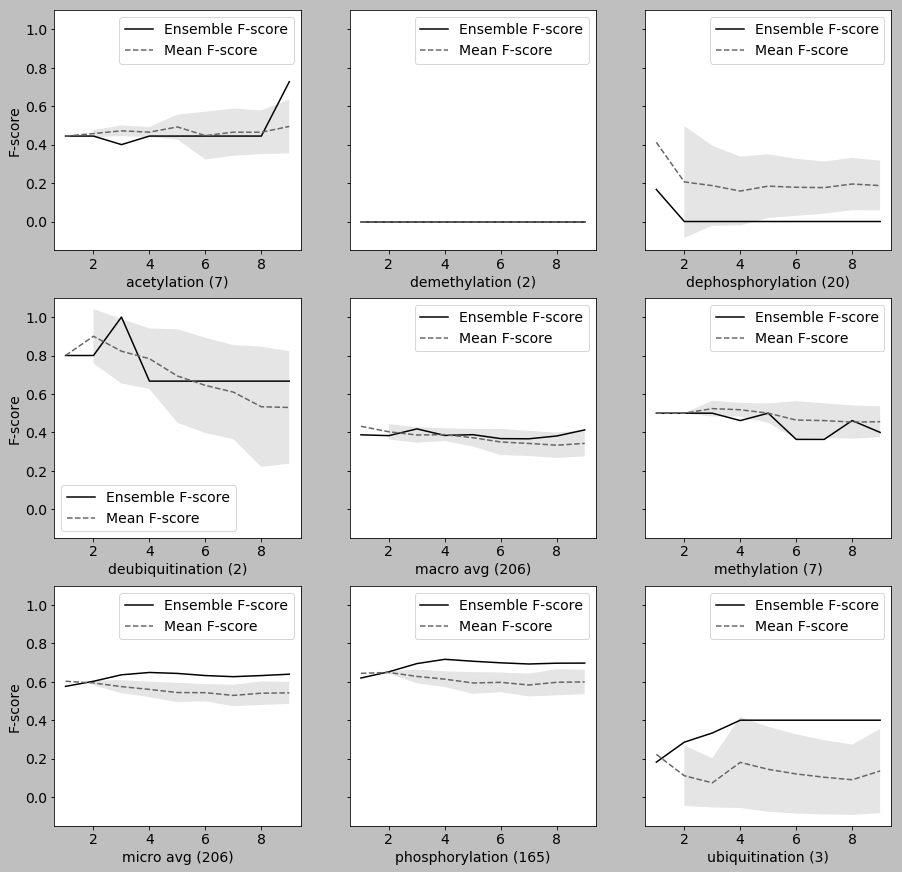

In [101]:
fig, axo = plt.subplots(3,3,figsize=(15,15), sharex=False, sharey=True)
ax=axo.reshape(-1)
colors = ["pink", "red", "blue", "green", "orange", "black", "lime", "mediumblue", "peru"]
line_type = []

for  i, (c, (label, df_e)) in enumerate(zip(colors, df_ensemble_size_compare.query("InteractionType not in [ 'weighted avg']").groupby('InteractionType'))):
    support = df_e["support"].iloc[0]
    df_e = df_e.sort_values(by=["ensemble_size"])


    df_v = df_ensemble_scores.query("InteractionType=='{}'".format(label)).groupby("ensemble_size").std()
    
    df_m = df_ensemble_scores.query("InteractionType=='{}'".format(label)).groupby("ensemble_size").mean()
    
    df_e.plot.line( ax=ax[i],label="Ensemble F-score" , x="ensemble_size" , y="f1-score")
    ax[i].plot(df_m.index.values , df_m["f1-score"].values, linestyle="dashed", label= "{}".format("Mean F-score"))
    ax[i].legend()
    
    ax[i].fill_between( df_v.index.values, df_m["f1-score"].values - df_v["f1-score"].values, df_m["f1-score"].values + df_v["f1-score"].values, alpha=0.1)
    ax[i].set_xlabel( "{} ({})".format(label, str(support))) 
    ax[i].set_ylabel( "F-score") 



plt.savefig("EnsembleSizeImpact.pdf")


plt.show()